In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
#import xgboost as xgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
#from sklearn.metrics import roc_auc_score
import gc
from functools import cmp_to_key
import time
import matplotlib.pyplot as plt
from numba import jit
from functools import reduce
import seaborn as sns
gc.enable()

dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }


In [2]:
print('Download Train and Test Data.\n')
%time train = pd.read_csv('/home/ryan/cs/datasets/microsoft/train.csv', dtype=dtypes, low_memory=True)
train['MachineIdentifier'] = train.index.astype('uint32')
%time test  = pd.read_csv('/home/ryan/cs/datasets/microsoft/test.csv',  dtype=dtypes, low_memory=True)
test['MachineIdentifier']  = test.index.astype('uint32')
osver_timestamps = np.load('/home/ryan/cs/datasets/microsoft/OSVersionTimestamps.npy')[()]
avsig_timestamps = np.load('/home/ryan/cs/datasets/microsoft/AvSigVersionTimestamps.npy')[()]
if 5244810 in train.index:
    train.loc[5244810,'AvSigVersion'] = '1.273.1144.0'
    train['AvSigVersion'].cat.remove_categories('1.2&#x17;3.1144.0',inplace=True)
    
gc.collect()

Download Train and Test Data.

CPU times: user 1min 15s, sys: 2.36 s, total: 1min 17s
Wall time: 1min 18s
CPU times: user 1min 7s, sys: 1.65 s, total: 1min 9s
Wall time: 1min 10s


201033

In [3]:
def condense_feature(df, col, category_map, fill_with=None):
    feature = df[col]
    reverse_map = {}
    default_val = None
    categories = feature.unique()
    categories = categories[~pd.isnull(categories)]
    
    for k, v_arr in category_map.items():
        if len(v_arr) != 0:
            for v in v_arr:       
                reverse_map[v] = k
                index = np.argwhere(categories==v)
                categories = np.delete(categories, index)         
        else:
            default_val = k
            
    for v in categories:
        reverse_map[v] = default_val
        
    condensed = df[col].map(reverse_map)
    if fill_with:
        condensed = condensed.fillna(fill_with)
    else:
        condensed = condensed.fillna(default_val)
    
    return condensed

def generate_count_feature(df, col, counts=None):
    if counts is None:
        feature = df[col]
        groups = df.groupby(col)
        counts = groups.size()
    count_feature = df[col].map(counts)
    
    return count_feature, counts

def group_battery(x):
    x = x.lower()
    if ('li' in x) or ('ion' in x):
        return 1
    else:
        return 0
    
def generate_freq_feature(df, col, on='HasDetections', frequencies=None):
#     print(frequencies)
    if frequencies is None:
        groups = df.groupby(col)
        sizes = groups.size()
        sums = groups.sum()[on]
        frequencies = sums/sizes
    freq_feature = df[col].map(frequencies)
    
    return freq_feature, frequencies

def generate_version_mapping(df, col, num_splits=4, fill_val='0.0.0.0'):
    feature = df[col].astype(str)
    feature.fillna(fill_val)
    versions = feature.unique()
    
    def version_compare(x, y):
        x_splits = x.split('.')
        y_splits = y.split('.')
        for x_val, y_val in zip(x_splits, y_splits):
            try:
                int_x = int(x_val)
            except:
                int_x = 0
            try:
                int_y = int(y_val)
            except:
                int_y = 0
            if int_x > int_y:
                return 1
            elif int_x < int_y:
                return -1
        return 0

    sorted_versions = sorted(versions, key=cmp_to_key(version_compare))
    mapping = {}
    for i, v in enumerate(sorted_versions):
        mapping[v] = i
        
    return feature.map(mapping)

def generate_split_version(df, col, num_splits=4):
    feature = df[col].astype(str)
    sv = pd.DataFrame()
    for i in range(num_splits):
        sv[col + '_' + str(i)] = feature.apply(lambda x: x.split('.')[i]).astype(np.int16)
        
    return sv

def create_age_feature(df, col, raw_timestamps):
    timestamps = {}
    for k, v in raw_timestamps.items():
        timestamps[k] = v.toordinal()
    maxval = max(list(timestamps.values()))
    for k, v in timestamps.items():
        timestamps[k] = maxval - timestamps[k]
        
    return df[col].map(timestamps)

In [4]:
def generate_count_df(df, cols, counts_map={}):
    count_df = pd.DataFrame()
    for col in cols:
        if col in counts_map:
            count_df[col + '_counts'], _ = generate_count_feature(df, col, counts=counts_map[col])
        else:
            count_df[col + '_counts'], counts_map[col] = generate_count_feature(df, col)
        
    return count_df, counts_map

def generate_two_count_df(df1, df2, cols, counts_map={}):
    count_df1 = pd.DataFrame()
    count_df2 = pd.DataFrame()
    features = pd.concat([df1, df2])
    for col in cols:
        counts = features[col].value_counts()
        count_df1[col + '_counts'] = df1[col].map(counts)
        count_df2[col + '_counts'] = df2[col].map(counts)
        
    count_df1 = count_df1.fillna(0).astype(np.int32)
    count_df2 = count_df2.fillna(0).astype(np.int32)
    return count_df1, count_df2

        
def generate_freq_df(df, cols, freqs_map={}):
    freq_df = pd.DataFrame()
    for col in cols:
        print('Generating frequency feature for ' + col + '...')
        if col in freqs_map:
            freq_df[col + '_freqs'], _ = generate_freq_feature(df, col, frequencies=freqs_map[col])
        else:
            freq_df[col + '_freqs'],  freqs_map[col] =  generate_freq_feature(df, col)
            
    return freq_df, freqs_map

def generate_category_df(df, cols):
    cat_df = pd.DataFrame()
    for col in cols:
        cat_df[col+'_cat'] = df[col].astype('category')
        
    return cat_df
        
def generate_boolean_df(df, cols):
    bool_df = pd.DataFrame()
    for col in cols:
        bool_df[col+'_bool'] = df[col].astype(np.bool)
        
    return bool_df
        
def generate_gb_df(df, cols):
    gb_df = pd.DataFrame()
    for col in cols:
        gb_df[col+'_gb'] = df[col].fillna(df[col].median()).apply(lambda x: int(x/1000))
        
    return gb_df


In [5]:
def trim_all(df_train, df_test, columns_to_trim, delete_time_sensitive=False, delete_nan_thresh=0.8, fill='new'):
    fe_train = pd.DataFrame()
    fe_test = pd.DataFrame()
    for i, col in enumerate(columns_to_trim):
        print(str(i+1) + '/' + str(len(columns_to_trim)) + ' Trimming ' + col + '...')
        tr_col, te_col, le_name_mapping = trim(df_train, df_test, col, fill=fill)
        if delete_time_sensitive and 'nan' in le_name_mapping:
            percent = (te_col.values == le_name_mapping['nan']).sum() / float(len(te_col))
            if percent < delete_nan_thresh:
                fe_train[col], fe_test[col] =  tr_col, te_col

            else:
                print('Deleted ' + col)
        else:
            fe_train[col], fe_test[col] =  tr_col, te_col
                    
        
    print('Done!')
    return fe_train, fe_test

def trim(raw_tr, raw_te, col, fill='new', factor=4, min_obs=1000):
    agg_tr = raw_tr.groupby(col).size().to_frame('tr_counts').reset_index()
    agg_te = raw_te.groupby(col).size().to_frame('te_counts').reset_index()
    
    agg = pd.merge(agg_tr, agg_te, on=col, how='outer')

    try:
        agg = agg.fillna(0)
    except:
        pass

    agg = agg[agg['tr_counts'] > min_obs].reset_index(drop=True)
    agg['total_counts'] = agg['tr_counts'] + agg['te_counts']
    agg = agg[(agg['tr_counts'] / agg['total_counts'] > (1.0/factor)) & (agg['tr_counts'] / agg['total_counts'] < ((factor-1.0)/factor))]
    agg[col+'_copy'] = agg[col]

    trim_tr = pd.merge(raw_tr[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy'].astype(str)
    trim_te = pd.merge(raw_te[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy'].astype(str)
    
    if fill == 'new':
        le = LabelEncoder().fit(trim_tr.values)
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        trim_tr = pd.Series(le.transform(trim_tr))
        trim_te = pd.Series(le.transform(trim_te))
        trim_tr = trim_tr.astype('category').rename(col+'_ztrim')
        trim_te = trim_te.astype('category').rename(col+'_ztrim')
    
    elif fill == 'ordinal':
        # should be same uniques
        mapping = ordinal_mapping(trim_tr.values)
        good_vals = []
        for g in mapping.keys():
            if g != 'nan':
                good_vals.append(float(g))
        good_vals.sort()

        trim_tr = fill_ordinal(raw_tr[col], trim_tr, good_vals).astype(float).rename(col+'_otrim')
        trim_te = fill_ordinal(raw_te[col], trim_te, good_vals).astype(float).rename(col+'_otrim')
        
        trim_tr = trim_tr.map(mapping)
        trim_te = trim_te.map(mapping)
                
    else:
        raise Exception('fill should be new or ordinal')
    
    return trim_tr, trim_te, mapping


def fill_ordinal(raw_series, series, good_vals):

    curr_index = 0
    len_good_vals = len(good_vals)
    
    sorted_series = series.argsort()

    for idx in sorted_series:
        
        if series[idx] == 'nan':
            if curr_index >= len_good_vals - 1:
                series[idx] = good_vals[-1]
            elif raw_series.iloc[idx] < good_vals[curr_index+1]:
                series[idx] = good_vals[curr_index]
            else:
                series[idx] = good_vals[curr_index+1]
                curr_index += 1
    return series


def ordinal_mapping(vals, fill_val=-1):
    feature = vals.astype(float)
    feature[np.isnan(feature)] = fill_val

    versions = np.unique(feature)
    
    def version_compare(x, y):

        try:
            int_x = int(x_val)
        except:
            int_x = 0
        try:
            int_y = int(y_val)
        except:
            int_y = 0
        if int_x > int_y:
            return 1
        elif int_x < int_y:
            return -1
        return 0

    sorted_versions = sorted(versions, key=cmp_to_key(version_compare))
    mapping = dict(zip(sorted_versions, range(len(sorted_versions))))
        
    return mapping

In [ ]:
# input raw df before trim: counts, condense, split_version, boolean, and non-categorical
def feature_engineer_1(df):

    fe = pd.DataFrame()
    other = pd.DataFrame()
    
    fe['MoreThanOneAV'] = condense_feature(df, 'AVProductsInstalled', {False: [0.0, 1.0], True: []}, fill_with=False).astype(bool)
    fe['SkuEdition_condensed'] = condense_feature(df, 'SkuEdition', {'1': ['Home'], '2': ['Pro'], '0':[]}).astype('category')
    fe['SmartScreen_condensed'] = condense_feature(df, 'SmartScreen', 
                                            {True: ['RequireAdmin', 'On', 'Warn', 'on', 'Enabled', 'warn', 'Block', 'Prompt', 'Promp', 'requireadmin', 'prompt', 'requireAdmin'], 
                                             False: []}).astype(np.bool)
    
    fe['BatteryType'] = df['Census_InternalBatteryType'].apply(group_battery)
      
    fe['MachineCost'] = df['Census_ProcessorCoreCount'] * 50 + df['Census_SystemVolumeTotalCapacity']/20000 \
                        + df['Census_TotalPhysicalRAM']/200
    
    fe['RiskFactor'] = df['Wdft_IsGamer'] + -1*fe['SmartScreen_condensed'] + -1*df['HasTpm'] + df['Firewall']
    
    other['AvSigAge'] = create_age_feature(df, 'AvSigVersion', avsig_timestamps)
    other['OsVerAge'] = create_age_feature(df, 'Census_OSVersion', osver_timestamps)
    fe['AvLastUpdated'] = other['OsVerAge'] - other['AvSigAge']
    
    split_cols = ['Census_OSVersion', 'AppVersion']
    
    gb_cols = ['Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']
    
    linear_columns = ['Census_ProcessorCoreCount', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 
                      'Census_InternalPrimaryDisplayResolutionHorizontal', 
                      'Census_InternalPrimaryDisplayResolutionVertical',]
    
    fe['OsBuildReleaseYear'] = df['OsBuildLab'].str.slice(start=-11, stop=-9).astype(np.int16)
    
    for lin_col in linear_columns:
        df[lin_col] = df[lin_col].astype(np.float32)
        fe[lin_col] = df[lin_col].fillna(df[lin_col].median())
    
    for split_col in split_cols:
        fe = fe.join(generate_split_version(df, split_col, num_splits=4))
    
    fe = fe.join(generate_gb_df(df, gb_cols))
    
    return fe

# input trimmed df
def feature_engineer_2(df, frequencies_map={}):
    
    fe = pd.DataFrame()
    
#     fe['EngineVersionMapped'] = generate_version_mapping(df, 'EngineVersion')
    fe['AppVersionMapped'] = generate_version_mapping(df, 'AppVersion')
    fe['Census_OSVersion'] = generate_version_mapping(df, 'OSVersion')
#     fe['AvSigVersionMapped'] = generate_version_mapping(df, 'AvSigVersion')
    
    freq_cols = ['OrganizationIdentifier', 'CountryIdentifier', 'IeVerIdentifier', 
                 'Census_ActivationChannel', 'Census_FirmwareManufacturerIdentifier', 
                 'Census_OSUILocaleIdentifier']
    
    freq_df, frequencies_map = generate_freq_df(df, freq_cols, freqs_map=frequencies_map)
    fe = fe.join(freq_df)
    
    # cost feature
    
    return fe, frequencies_map
    

In [2]:
print('Feature engineering train features...')
fe1_train = feature_engineer_1(train)
print('Feature engineering test features...')
fe1_test = feature_engineer_1(test)

Feature engineering train features...


NameError: name 'feature_engineer_1' is not defined

In [136]:
columns_to_delete = ['HasDetections', # label
                     'MachineIdentifier', # id
                     'DefaultBrowsersIdentifier', # nan columns
                     'PuaMode',
                     'ProductName', # imbalanced columns
                     'IsBeta',
                     'IsSxsPassiveMode',
                     'HasTpm',
                     'AutoSampleOptIn',
                     'PuaMode',
                     'UacLuaenable',
                     'Census_DeviceFamily',
                     'Census_ProcessorClass',
                     'Census_IsPortableOperatingSystem',
                     'Census_IsFlightsDisabled',
                     'Census_IsVirtualDevice',
                     'Census_OSSkuName', # overlap columns
                     'OsVer',
                     'Census_OSArchitecture',
                     'Census_OSInstallLanguageIdentifier',
                     'Census_InternalBatteryNumberOfCharges' # strange values
                    ]

# from fe1
non_categorical_cols = ['Census_ProcessorCoreCount', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 
                        'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 
                        'Census_TotalPhysicalRAM', 'Census_PrimaryDiskTotalCapacity', ]

columns_to_process = []
for col in train.columns:
    if col not in columns_to_delete + non_categorical_cols:
        columns_to_process.append(col)

%time trim_train, trim_test = trim_all(train, test, columns_to_process, delete_time_sensitive=True)

0/58 Trimming EngineVersion...
Deleted EngineVersion
1/58 Trimming AppVersion...
2/58 Trimming AvSigVersion...
Deleted AvSigVersion
3/58 Trimming RtpStateBitfield...
4/58 Trimming AVProductStatesIdentifier...
5/58 Trimming AVProductsInstalled...
6/58 Trimming AVProductsEnabled...
7/58 Trimming CountryIdentifier...
8/58 Trimming CityIdentifier...
9/58 Trimming OrganizationIdentifier...
10/58 Trimming GeoNameIdentifier...
11/58 Trimming LocaleEnglishNameIdentifier...
12/58 Trimming Platform...
13/58 Trimming Processor...
Deleted Processor
14/58 Trimming OsBuild...
15/58 Trimming OsSuite...
16/58 Trimming OsPlatformSubRelease...
17/58 Trimming OsBuildLab...
18/58 Trimming SkuEdition...
19/58 Trimming IsProtected...
20/58 Trimming SMode...
Deleted SMode
21/58 Trimming IeVerIdentifier...
22/58 Trimming SmartScreen...
23/58 Trimming Firewall...
24/58 Trimming Census_MDC2FormFactor...
25/58 Trimming Census_OEMNameIdentifier...
26/58 Trimming Census_OEMModelIdentifier...
27/58 Trimming Census_

In [52]:
# ordinal_columns = ['AppVersion_1',]
#                    'AppVersion_2', 'AppVersion_3',  
#                    'Census_OSVersion_3', 'EngineVersion_2']
# ordinal_columns = ['AvSigVersion_2', 'Census_OSVersion_3']
ordinal_columns = ['Census_OSVersion_3', '']
%time ord_train, ord_test = trim_all(fe1_train, fe1_test, ordinal_columns, fill='ordinal')

0/2 Trimming AvSigVersion_2...
1/2 Trimming Census_OSVersion_3...
Done!
CPU times: user 10min 3s, sys: 1.01 s, total: 10min 4s
Wall time: 10min 4s


In [140]:
trim_train['HasDetections'] = train['HasDetections']

In [141]:
print('Feature engineering train features (part 2)...')
fe2_train, freqs = feature_engineer_2(trim_train)
print('Feature engineering test features (part 2)...')
fe2_test, _ = feature_engineer_2(trim_test, frequencies_map=freqs)

Feature engineering train features (part 2)...
Generating frequency feature for OrganizationIdentifier...
Generating frequency feature for CountryIdentifier...
Generating frequency feature for IeVerIdentifier...
Generating frequency feature for Census_ActivationChannel...
Generating frequency feature for Census_FirmwareManufacturerIdentifier...
Generating frequency feature for Census_OSUILocaleIdentifier...
Feature engineering test features (part 2)...
Generating frequency feature for OrganizationIdentifier...
Generating frequency feature for CountryIdentifier...
Generating frequency feature for IeVerIdentifier...
Generating frequency feature for Census_ActivationChannel...
Generating frequency feature for Census_FirmwareManufacturerIdentifier...
Generating frequency feature for Census_OSUILocaleIdentifier...


In [229]:
# count_cols = ['EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier',
#               'CountryIdentifier', 'Census_OSVersion', 'CityIdentifier', 'OrganizationIdentifier', 
#               'GeoNameIdentifier', 'OsBuild', 
#               'OsBuildLab', 'IeVerIdentifier', 'Census_MDC2FormFactor', 'Census_OEMNameIdentifier', 
#               'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 
#               'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 
#               'Census_PowerPlatformRoleName', 'Census_OSBranch', 'Census_OSBuildNumber', 
#               'Census_OSBuildRevision','Census_OSEdition','Census_OSInstallTypeName', 
#               'Census_OSUILocaleIdentifier', 'Census_ActivationChannel','Census_FirmwareManufacturerIdentifier',
#               'Census_FirmwareVersionIdentifier', 'Census_IsTouchEnabled']

count_cols = ['CityIdentifier', 'CountryIdentifier','GeoNameIdentifier', 'Census_FirmwareVersionIdentifier', 
              'Census_ProcessorModelIdentifier',  'LocaleEnglishNameIdentifier',
              'Census_OSVersion', 'Census_OSBuildRevision', 'Census_OEMNameIdentifier',
              'AVProductStatesIdentifier', 'Census_OSUILocaleIdentifier']

fe_count_cols = ['AppVersion_1', 'AppVersion_2']

count_df1_train, count_df1_test = generate_two_count_df(train, test, count_cols)
count_df2_train, count_df2_test = generate_two_count_df(fe1_train, fe1_test, fe_count_cols)

In [150]:
trim_train = trim_train.drop('HasDetections', axis=1)

In [294]:
# join fe1, fe2, and trimmed
train_final = reduce(lambda left, right: left.join(right, rsuffix='_oops'), [trim_train, fe1_train, count_df1_train, count_df2_train])

test_final = reduce(lambda left, right: left.join(right, rsuffix='_oops'), [trim_test, fe1_test, count_df1_test, count_df2_test])


In [295]:
for i in train_final.columns:
    if train_final[i].isnull().values.any():
        train_final[i] = train_final[i].fillna(0)
    if test_final[i].isnull().values.any():
        test_final[i] = test_final[i].fillna(0)

In [297]:
train_final = train_final.drop([ 'Census_OSVersion_0', 'Census_OSVersion_1', 
                               'AppVersion_0', 
                                 'Platform', 
                                'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable',
                                 'Census_OSVersion_2',  'Census_OSVersion_counts'], axis=1)
test_final = test_final.drop([ 'Census_OSVersion_0', 'Census_OSVersion_1', 
                               'AppVersion_0', 
                                 'Platform', 
                                'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable',
                                 'Census_OSVersion_2',  'Census_OSVersion_counts'], axis=1)

In [236]:
save_df = False
if save_df:
    print('Saving train dataframe...')
    %time train_final.to_csv('train_df.csv')
    print('Saving test dataframe...')
    %time test_final.to_csv('test_df.csv')
    print('Done!')
    
load_df = False
if load_df:
    print('Loading train dataframe...')
    %time train_final = pd.read_csv('train_df.csv')
    print('Loading test dataframe...')
    %time test_final = pd.read_csv('test_df.csv')

In [237]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [298]:
train_final = reduce_mem_usage(train_final)
test_final = reduce_mem_usage(test_final)

Mem. usage decreased to 2093.01 Mb (36.3% reduction)
Mem. usage decreased to 1543.06 Mb (16.3% reduction)


In [299]:
y_trn = np.array(train['HasDetections'])
gc.collect()

36

In [240]:
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred

In [278]:
def train_model(X, y, fold_idx, params, plot_feature_importance=True, ):
    result_dict = {}
    feature_importance = pd.DataFrame()
    counter = 0
    result_dict['feature_importance'] = []

    for idx_trn, idx_val in fold_idx:

        print('Fold {}\n'.
              format(counter + 1))
         
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]

        
#         X_trn, X_val = csr_matrix(X_trn, dtype='float32'), csr_matrix(X_val, dtype='float32')
        y_trn, y_val = y[idx_trn], y[idx_val]

        dat_trn = lgb.Dataset(X_trn, label=y_trn)
        dat_val = lgb.Dataset(X_val, label=y_val)

        print('Beginning training...')
        start_time = time.time()
        model = lgb.train(params, dat_trn, valid_sets = [dat_trn, dat_val], verbose_eval=100, feval=eval_auc, num_boost_round=1200, early_stopping_rounds=100)
        print('Training took {0:.2f} minutes.'.format((time.time()-start_time)/60))
        
        del dat_trn, dat_val, X_trn, X_val
        
        feature_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importance()})
        result_dict['feature_importance'].append(feature_df)
        sorted_feat = feature_df.sort_values(by='importance', ascending=False)
        plt.figure(figsize=(10, 10))
        sns.barplot(x='importance', y='feature', data=sorted_feat[:50])
        print('Most useless features: ')
        print(sorted_feat[-20:])
        plt.title('LGB Features for fold')
        plt.show()

        counter += 1
        gc.collect()
        
    return result_dict


def train_and_test_model(X, X_test, y, params, num_folds=5, plot_feature_importance=True, ):
    result_dict = {}
    feature_importance = pd.DataFrame()
    fold_predictions = []
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=15)
    
    if X_test is not None:
        result_dict['averaged_prediction'] =  np.zeros(len(X_test))
    else:
        result_dict['averaged_prediction'] =  np.zeros(1)
    counter = 0
    result_dict['feature_importance'] = []
    result_dict['predictions'] = []


    for fold_n, (idx_trn, idx_val) in enumerate(folds.split(X, y)):

        print('Fold {}\n'.
              format(counter + 1))
         
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]

        
#         X_trn, X_val = csr_matrix(X_trn, dtype='float32'), csr_matrix(X_val, dtype='float32')
        y_trn, y_val = y[idx_trn], y[idx_val]

        dat_trn = lgb.Dataset(X_trn, label=y_trn)
        dat_val = lgb.Dataset(X_val, label=y_val)

        print('Beginning training...')
        start_time = time.time()
        model = lgb.train(params, dat_trn, valid_sets = [dat_trn, dat_val], verbose_eval=100, feval=eval_auc, num_boost_round=1200, early_stopping_rounds=100)
        print('Training took {0:.2f} minutes.'.format((time.time()-start_time)/60))
        
        del dat_trn, dat_val, X_trn, X_val
        
        if X_test is not None:
            print('Beginning prediction...')
            start_time = time.time()
#             X_test = csr_matrix(X_test, dtype='float32')
            y_hat = model.predict(X_test, num_iteration=model.best_iteration)
            result_dict['predictions'].append(y_hat)
            result_dict['averaged_prediction'] += y_hat
            print('Prediction took {0:.2f} minutes.'.format((time.time()-start_time)/60))

        feature_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importance()})
        result_dict['feature_importance'].append(feature_df)
        sorted_feat = feature_df.sort_values(by='importance', ascending=False)
        plt.figure(figsize=(10, 10))
        sns.barplot(x='importance', y='feature', data=sorted_feat[:50])
        print('Most useless features: ')
        print(sorted_feat[-20:])
        plt.title('LGB Features for fold')
        counter += 1
        gc.collect()

    if X_test is not None:
        result_dict['averaged_prediction'] /= counter
        
    return result_dict

def create_submission(result_dict, fname):
    submission = pd.read_csv('/home/ryan/cs/datasets/microsoft/sample_submission.csv')
    submission['HasDetections'] = result_dict['averaged_prediction']
    submission.to_csv('submissions/' + fname, index=False)
    return submission

def convert_to_float(df):
    for col in df.columns:
        df[col] = df[col].astype(np.float32)
    return df

In [286]:

params = {
    'max_depth': 9,
    'num_leaves': 255,
    'objective': 'binary',
    'colsample_bytree': 0.28,
    'learning_rate': 0.3,
    'bagging_fraction': 0.9,
    'bagging_freq': 50
}

test_params = {
    'max_depth': 9,
    'num_leaves': 255,
    'objective': 'binary',
    'colsample_bytree': 0.28,
    'learning_rate': 0.2,
    'bagging_fraction': 0.9,
    'bagging_freq': 50
}


In [243]:
curr_train = pd.DataFrame()
curr_test = pd.DataFrame()
gb_cols = ['Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']

linear_columns = ['Census_ProcessorCoreCount', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalPrimaryDisplayResolutionVertical',]
for col in trim_train.columns:
    curr_train[col] = trim_train[col]
    curr_test[col] = trim_test[col]
    
for col in gb_cols:
    curr_train[col+'_gb'] = fe1_train[col+'_gb']
    curr_test[col+'_gb'] = fe1_test[col+'_gb']

for col in linear_columns:
    curr_train[col] = fe1_train[col]
    curr_test[col] = fe1_test[col]

In [91]:
for col in curr_train:
    curr_train[col] = curr_train[col].astype(np.float32)
    curr_test[col] = curr_test[col].astype(np.float32)

In [251]:
avsig2_trn = train['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype(np.int16)
avsig2_test = test['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype(np.int16)

In [261]:
fold1_idx = avsig2_trn.index[avsig2_trn<275]
fold2_idx = avsig2_trn.index[avsig2_trn>=275]

fold_idx = [(fold1_idx, fold2_idx), 
            (fold2_idx, fold1_idx)]

In [300]:
train_final['OsBuildReleaseYear'] = train_final['OsBuildReleaseYear'].astype(np.int16)

In [275]:
curr_train = pd.DataFrame()
curr_test = pd.DataFrame()
for col in train_final:
    curr_train[col] =  train_final[col].astype(np.float32)
#     curr_test[col] =  trim_train[col].astype(np.float32)

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.585948	training's auc: 0.751583	valid_1's binary_logloss: 0.62528	valid_1's auc: 0.702908
[200]	training's binary_logloss: 0.576107	training's auc: 0.762898	valid_1's binary_logloss: 0.624089	valid_1's auc: 0.705155
[300]	training's binary_logloss: 0.56846	training's auc: 0.771632	valid_1's binary_logloss: 0.624705	valid_1's auc: 0.704874
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.574839	training's auc: 0.764351	valid_1's binary_logloss: 0.624033	valid_1's auc: 0.70532
Training took 9.70 minutes.
Most useless features: 
                                   feature  importance
39                 Census_GenuineStateName         240
30              Census_InternalBatteryType         237
29            Census_PowerPlatformRoleName         224
57                      OsBuildReleaseYear         215
58               Census_ProcessorCoreCount  

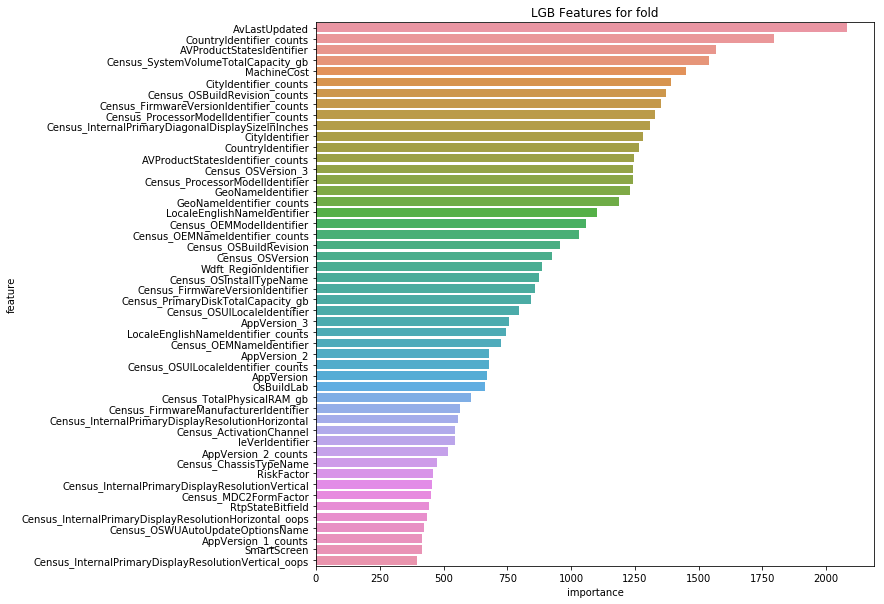

Fold 2

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.59951	training's auc: 0.734805	valid_1's binary_logloss: 0.624985	valid_1's auc: 0.707509
[200]	training's binary_logloss: 0.589365	training's auc: 0.747698	valid_1's binary_logloss: 0.6252	valid_1's auc: 0.708269
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.596113	training's auc: 0.739158	valid_1's binary_logloss: 0.624625	valid_1's auc: 0.708368
Training took 7.21 minutes.
Most useless features: 
                                   feature  importance
39                 Census_GenuineStateName         141
14                              SkuEdition         136
41                       Census_FlightRing         130
30              Census_InternalBatteryType         128
57                      OsBuildReleaseYear         127
33                    Census_OSBuildNumber         122
42                   Census_ThresholdOptIn         108
58   

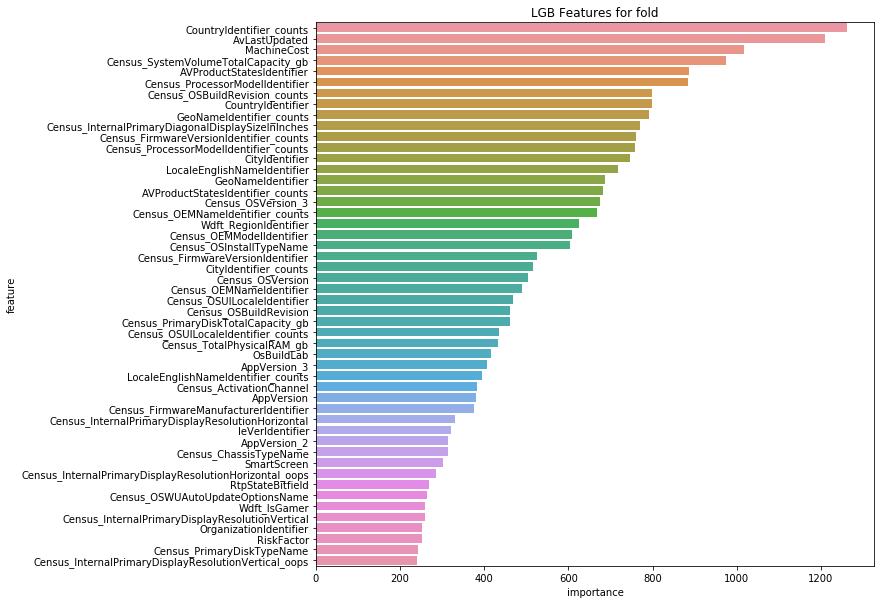

{'feature_importance': [                                              feature  importance
  0                                          AppVersion         671
  1                                    RtpStateBitfield         442
  2                           AVProductStatesIdentifier        1567
  3                                 AVProductsInstalled         292
  4                                   AVProductsEnabled         137
  5                                   CountryIdentifier        1268
  6                                      CityIdentifier        1280
  7                              OrganizationIdentifier         339
  8                                   GeoNameIdentifier        1232
  9                         LocaleEnglishNameIdentifier        1102
  10                                            OsBuild         390
  11                                            OsSuite         255
  12                               OsPlatformSubRelease         279
  13                      

In [279]:
train_model(convert_to_float(train_final), y_trn, fold_idx, params)

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.587084	training's auc: 0.75044	valid_1's binary_logloss: 0.62514	valid_1's auc: 0.701247
[200]	training's binary_logloss: 0.577623	training's auc: 0.761501	valid_1's binary_logloss: 0.624019	valid_1's auc: 0.703494
[300]	training's binary_logloss: 0.570591	training's auc: 0.769448	valid_1's binary_logloss: 0.62456	valid_1's auc: 0.703656
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.576356	training's auc: 0.762965	valid_1's binary_logloss: 0.623948	valid_1's auc: 0.703618
Training took 9.56 minutes.
Most useless features: 
                                    feature  importance
46               Census_IsSecureBootEnabled         259
67                       Census_OSVersion_2         249
4                         AVProductsEnabled         214
12                                  OsSuite         202
43                    Census_ThresholdO

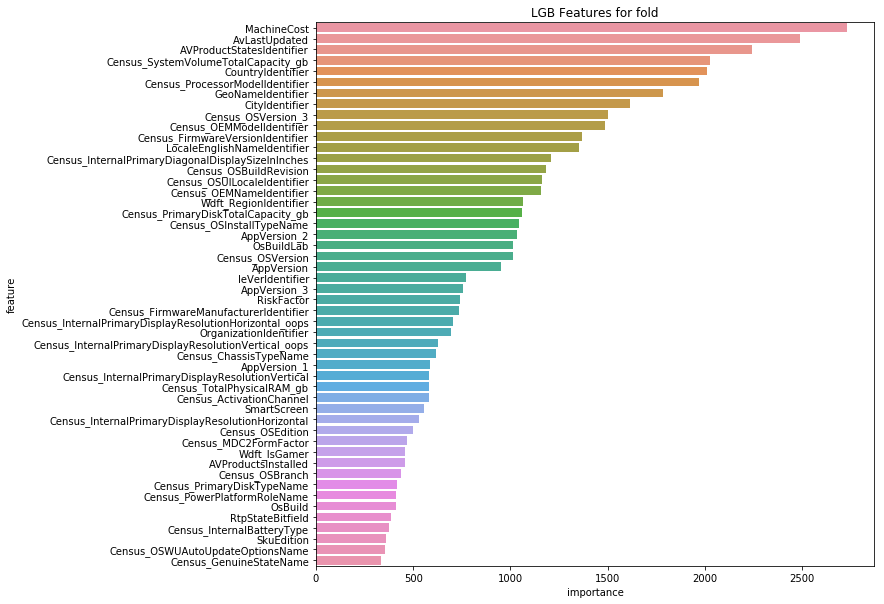

Fold 2

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.601007	training's auc: 0.732858	valid_1's binary_logloss: 0.624222	valid_1's auc: 0.709037
[200]	training's binary_logloss: 0.59106	training's auc: 0.745775	valid_1's binary_logloss: 0.624033	valid_1's auc: 0.709781
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.595692	training's auc: 0.739835	valid_1's binary_logloss: 0.623404	valid_1's auc: 0.71038
Training took 7.35 minutes.
Most useless features: 
                                    feature  importance
54                     SkuEdition_condensed         151
31               Census_InternalBatteryType         151
4                         AVProductsEnabled         149
12                                  OsSuite         147
19                                 Firewall         135
26               Census_HasOpticalDiskDrive         132
53                            MoreThanOneAV         

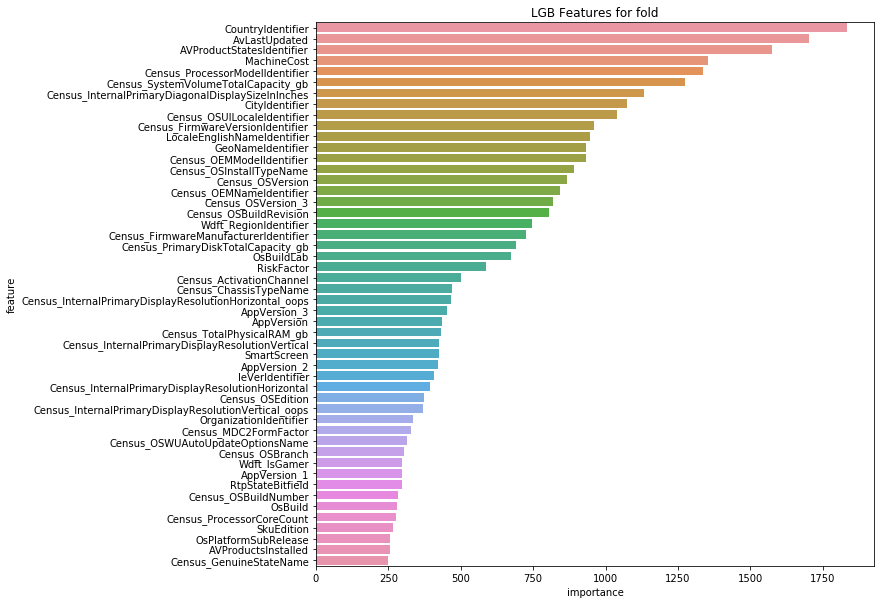

{'feature_importance': [                                              feature  importance
  0                                          AppVersion         950
  1                                    RtpStateBitfield         385
  2                           AVProductStatesIdentifier        2242
  3                                 AVProductsInstalled         457
  4                                   AVProductsEnabled         214
  5                                   CountryIdentifier        2011
  6                                      CityIdentifier        1613
  7                              OrganizationIdentifier         694
  8                                   GeoNameIdentifier        1787
  9                         LocaleEnglishNameIdentifier        1354
  10                                           Platform         115
  11                                            OsBuild         410
  12                                            OsSuite         202
  13                      

In [281]:
curr_train = trim_train.join(fe1_train, rsuffix='_oops')
train_model(convert_to_float(curr_train), y_trn, fold_idx, params)

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.592702	training's auc: 0.744299	valid_1's binary_logloss: 0.627345	valid_1's auc: 0.697567
[200]	training's binary_logloss: 0.583748	training's auc: 0.755037	valid_1's binary_logloss: 0.627407	valid_1's auc: 0.697415
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.590426	training's auc: 0.746991	valid_1's binary_logloss: 0.626899	valid_1's auc: 0.698367
Training took 6.73 minutes.
Most useless features: 
                                    feature  importance
13                     OsPlatformSubRelease         237
31               Census_InternalBatteryType         211
51                             Wdft_IsGamer         209
15                               SkuEdition         199
30             Census_PowerPlatformRoleName         188
4                         AVProductsEnabled         164
42                        Census_FlightRing       

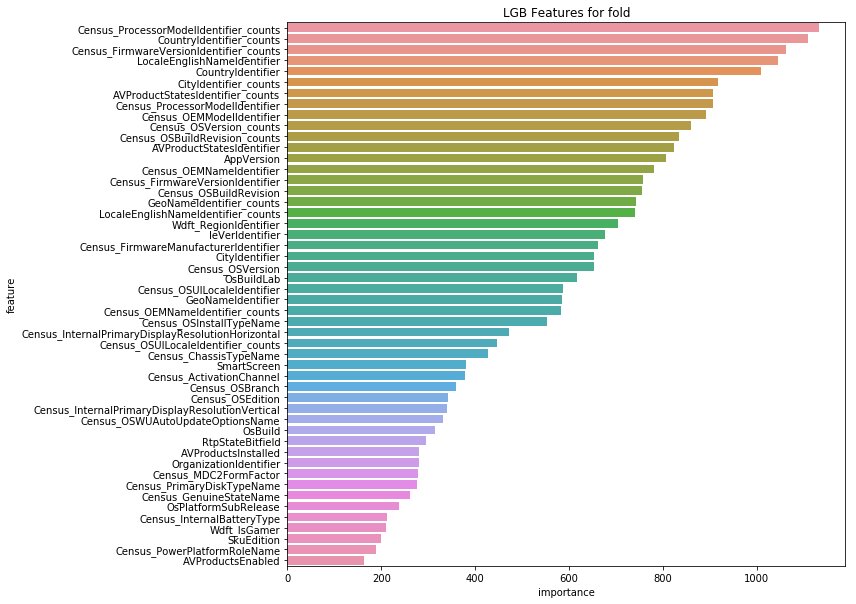

Fold 2

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.603755	training's auc: 0.729351	valid_1's binary_logloss: 0.620653	valid_1's auc: 0.711149
[200]	training's binary_logloss: 0.593899	training's auc: 0.742105	valid_1's binary_logloss: 0.620503	valid_1's auc: 0.712156
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.600513	training's auc: 0.733586	valid_1's binary_logloss: 0.620206	valid_1's auc: 0.712018
Training took 6.74 minutes.
Most useless features: 
                                    feature  importance
40                  Census_GenuineStateName         250
13                     OsPlatformSubRelease         249
15                               SkuEdition         222
51                             Wdft_IsGamer         217
30             Census_PowerPlatformRoleName         202
19                                 Firewall         144
12                                  OsSuite       

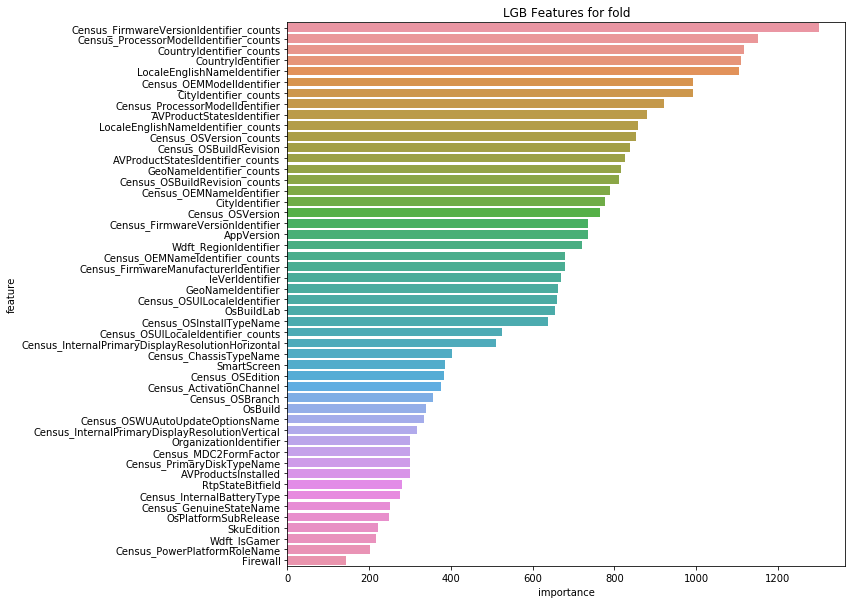

{'feature_importance': [                                              feature  importance
  0                                          AppVersion         807
  1                                    RtpStateBitfield         295
  2                           AVProductStatesIdentifier         824
  3                                 AVProductsInstalled         281
  4                                   AVProductsEnabled         164
  5                                   CountryIdentifier        1009
  6                                      CityIdentifier         654
  7                              OrganizationIdentifier         280
  8                                   GeoNameIdentifier         584
  9                         LocaleEnglishNameIdentifier        1044
  10                                           Platform          83
  11                                            OsBuild         314
  12                                            OsSuite         130
  13                      

In [283]:
curr_train = trim_train.join(count_df1_train, rsuffix='_oops')
train_model(convert_to_float(curr_train), y_trn, fold_idx, params)

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.593961	training's auc: 0.742649	valid_1's binary_logloss: 0.627946	valid_1's auc: 0.694956
[200]	training's binary_logloss: 0.585956	training's auc: 0.752263	valid_1's binary_logloss: 0.628271	valid_1's auc: 0.69476
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.587045	training's auc: 0.75097	valid_1's binary_logloss: 0.626624	valid_1's auc: 0.697637
Training took 8.40 minutes.
Most useless features: 
                                    feature  importance
36                         Census_OSEdition         485
1                          RtpStateBitfield         481
31               Census_InternalBatteryType         410
13                     OsPlatformSubRelease         391
15                               SkuEdition         381
40                  Census_GenuineStateName         367
42                        Census_FlightRing         

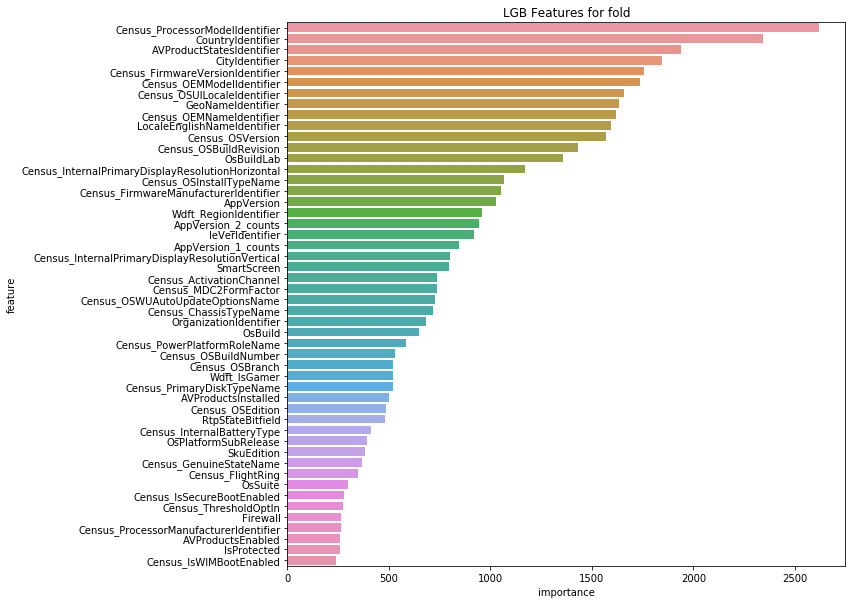

Fold 2

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.606061	training's auc: 0.72611	valid_1's binary_logloss: 0.621763	valid_1's auc: 0.709781
[200]	training's binary_logloss: 0.596958	training's auc: 0.737995	valid_1's binary_logloss: 0.621797	valid_1's auc: 0.710708
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.602644	training's auc: 0.730645	valid_1's binary_logloss: 0.621228	valid_1's auc: 0.710755
Training took 6.73 minutes.
Most useless features: 
                                    feature  importance
33                          Census_OSBranch         297
15                               SkuEdition         285
12                                  OsSuite         267
13                     OsPlatformSubRelease         265
31               Census_InternalBatteryType         255
40                  Census_GenuineStateName         234
36                         Census_OSEdition        

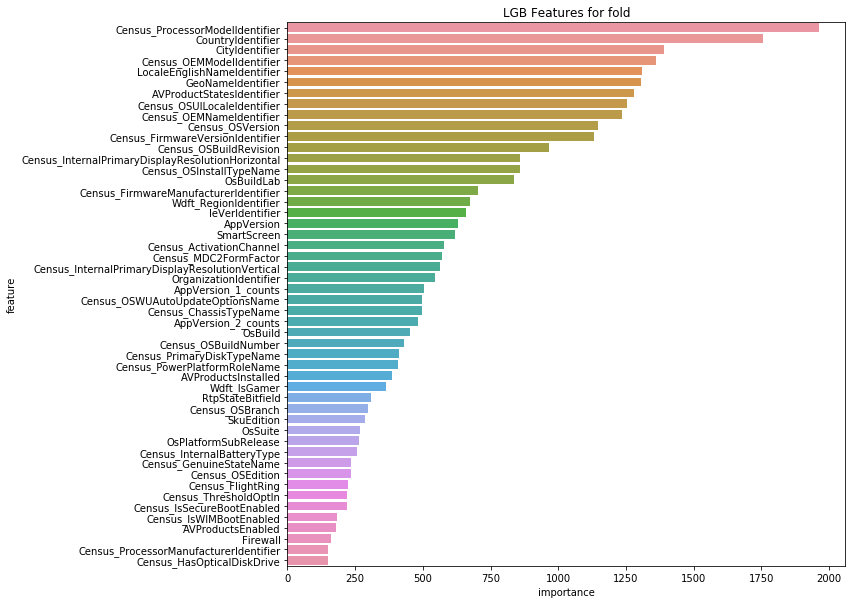

{'feature_importance': [                                              feature  importance
  0                                          AppVersion        1026
  1                                    RtpStateBitfield         481
  2                           AVProductStatesIdentifier        1939
  3                                 AVProductsInstalled         501
  4                                   AVProductsEnabled         261
  5                                   CountryIdentifier        2341
  6                                      CityIdentifier        1844
  7                              OrganizationIdentifier         682
  8                                   GeoNameIdentifier        1635
  9                         LocaleEnglishNameIdentifier        1594
  10                                           Platform         135
  11                                            OsBuild         647
  12                                            OsSuite         296
  13                      

In [282]:
curr_train = trim_train.join(count_df2_train, rsuffix='_oops')
train_model(convert_to_float(curr_train), y_trn, fold_idx, params)

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.595096	training's auc: 0.741758	valid_1's binary_logloss: 0.627768	valid_1's auc: 0.693415
[200]	training's binary_logloss: 0.587086	training's auc: 0.751388	valid_1's binary_logloss: 0.626945	valid_1's auc: 0.695407
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.587158	training's auc: 0.751295	valid_1's binary_logloss: 0.626934	valid_1's auc: 0.695416
Training took 8.80 minutes.
Most useless features: 
                                    feature  importance
34                     Census_OSBuildNumber         554
1                          RtpStateBitfield         553
3                       AVProductsInstalled         515
13                     OsPlatformSubRelease         511
40                  Census_GenuineStateName         407
46               Census_IsSecureBootEnabled         393
16                              IsProtected       

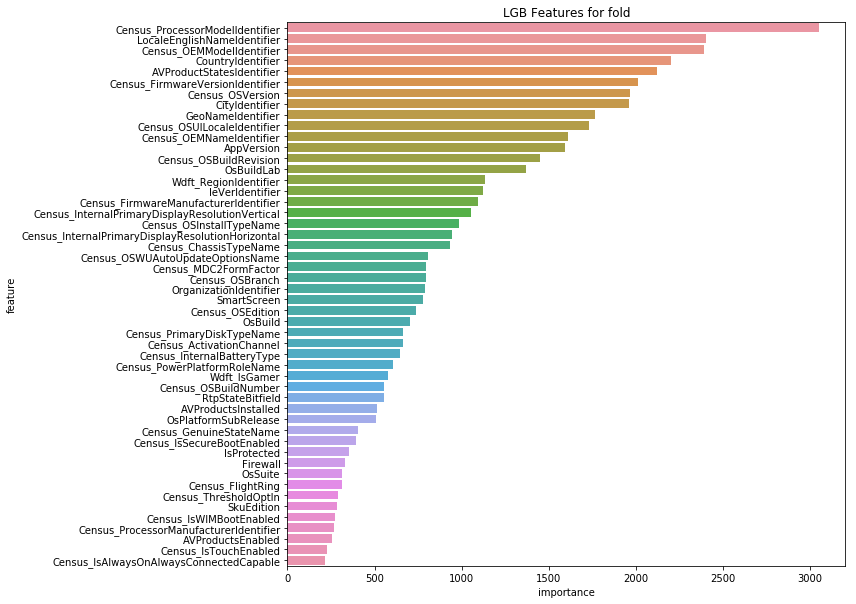

Fold 2

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.60666	training's auc: 0.725163	valid_1's binary_logloss: 0.616305	valid_1's auc: 0.715425
[200]	training's binary_logloss: 0.597456	training's auc: 0.737332	valid_1's binary_logloss: 0.615315	valid_1's auc: 0.717163
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.598039	training's auc: 0.736606	valid_1's binary_logloss: 0.615243	valid_1's auc: 0.71721
Training took 8.39 minutes.
Most useless features: 
                                    feature  importance
51                             Wdft_IsGamer         532
13                     OsPlatformSubRelease         505
3                       AVProductsInstalled         486
1                          RtpStateBitfield         440
40                  Census_GenuineStateName         381
46               Census_IsSecureBootEnabled         342
42                        Census_FlightRing         

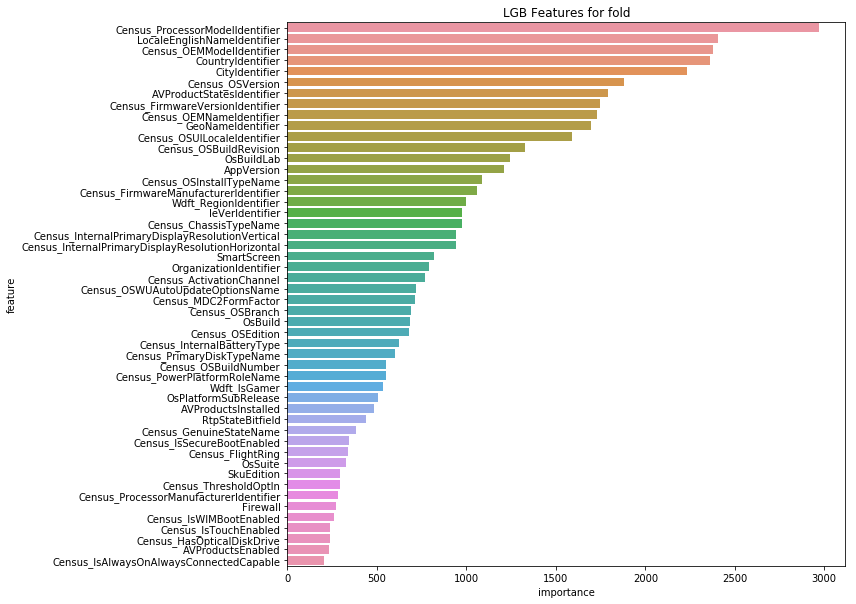

{'feature_importance': [                                              feature  importance
  0                                          AppVersion        1595
  1                                    RtpStateBitfield         553
  2                           AVProductStatesIdentifier        2123
  3                                 AVProductsInstalled         515
  4                                   AVProductsEnabled         255
  5                                   CountryIdentifier        2202
  6                                      CityIdentifier        1964
  7                              OrganizationIdentifier         790
  8                                   GeoNameIdentifier        1764
  9                         LocaleEnglishNameIdentifier        2406
  10                                           Platform         135
  11                                            OsBuild         706
  12                                            OsSuite         316
  13                      

In [284]:
train_model(convert_to_float(trim_train), y_trn, fold_idx, params)

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.599876	training's auc: 0.734768	valid_1's binary_logloss: 0.603988	valid_1's auc: 0.728977
[200]	training's binary_logloss: 0.592382	training's auc: 0.744085	valid_1's binary_logloss: 0.600289	valid_1's auc: 0.733507
[300]	training's binary_logloss: 0.587271	training's auc: 0.750272	valid_1's binary_logloss: 0.598745	valid_1's auc: 0.735332
[400]	training's binary_logloss: 0.583352	training's auc: 0.755052	valid_1's binary_logloss: 0.598153	valid_1's auc: 0.735994
[500]	training's binary_logloss: 0.579422	training's auc: 0.759782	valid_1's binary_logloss: 0.59763	valid_1's auc: 0.73664
[600]	training's binary_logloss: 0.575893	training's auc: 0.764084	valid_1's binary_logloss: 0.597369	valid_1's auc: 0.73698
[700]	training's binary_logloss: 0.572534	training's auc: 0.768117	valid_1's binary_logloss: 0.597287	valid_1's auc: 0.737098
[800]	training's binary_logl

[300]	training's binary_logloss: 0.587672	training's auc: 0.749822	valid_1's binary_logloss: 0.598312	valid_1's auc: 0.736165
[400]	training's binary_logloss: 0.583416	training's auc: 0.754987	valid_1's binary_logloss: 0.597475	valid_1's auc: 0.737154
[500]	training's binary_logloss: 0.57976	training's auc: 0.759397	valid_1's binary_logloss: 0.597053	valid_1's auc: 0.737675
[600]	training's binary_logloss: 0.57634	training's auc: 0.763509	valid_1's binary_logloss: 0.596745	valid_1's auc: 0.738018
[700]	training's binary_logloss: 0.573048	training's auc: 0.767436	valid_1's binary_logloss: 0.596662	valid_1's auc: 0.738135
[800]	training's binary_logloss: 0.569916	training's auc: 0.771221	valid_1's binary_logloss: 0.59667	valid_1's auc: 0.73818
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.570776	training's auc: 0.770191	valid_1's binary_logloss: 0.596602	valid_1's auc: 0.738259
Training took 27.81 minutes.
Beginning prediction...
Prediction took 1.82 minutes.
Most

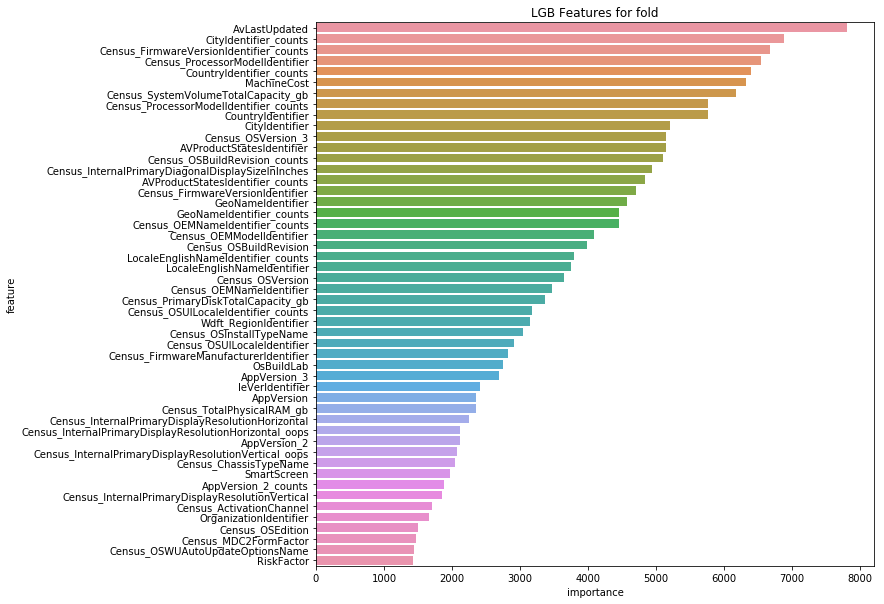

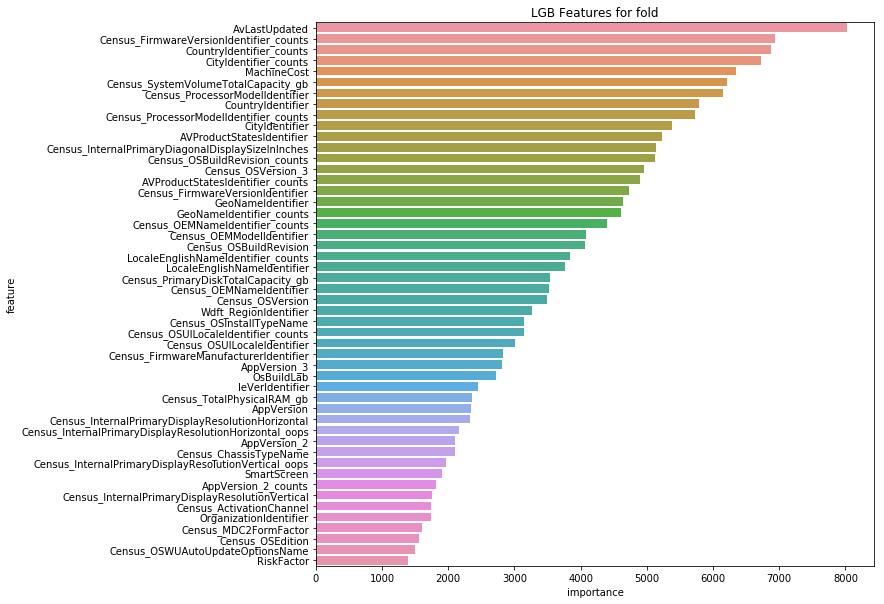

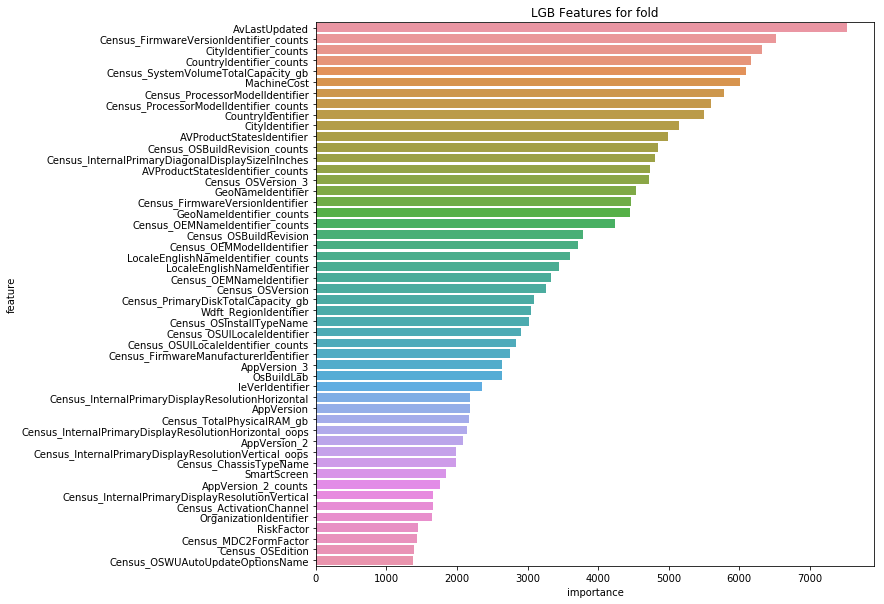

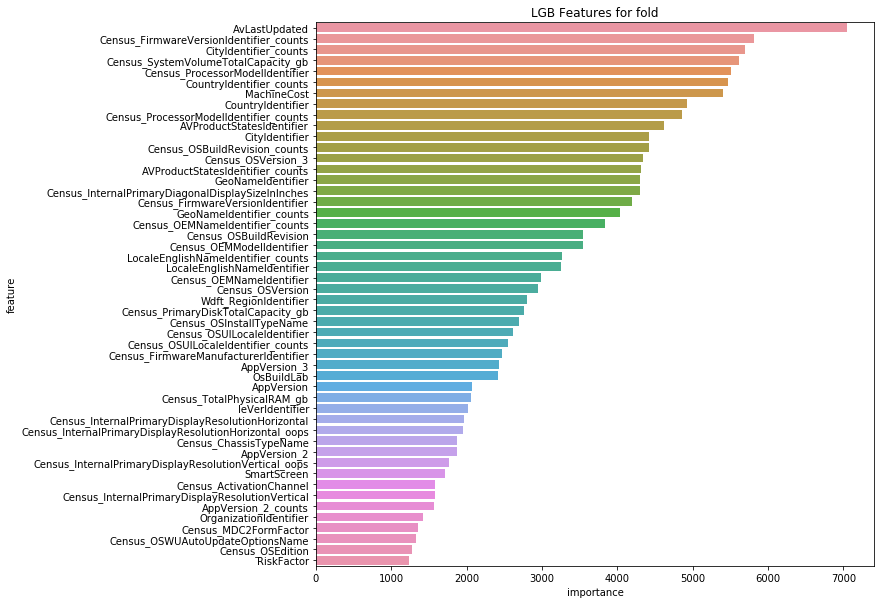

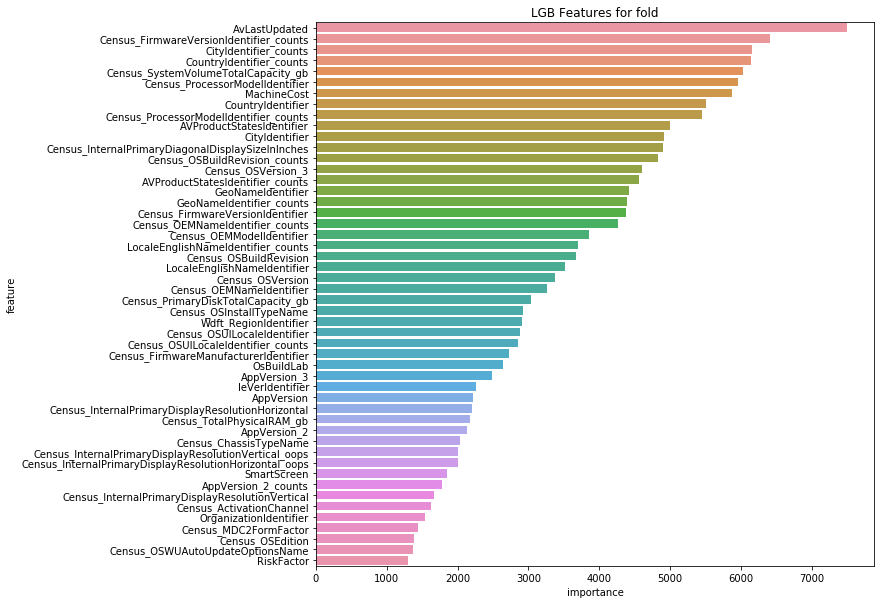

In [287]:
sub = train_and_test_model(convert_to_float(train_final), convert_to_float(test_final), y_trn, test_params, num_folds=5, plot_feature_importance=True, )

In [301]:
ts_dropped = train_final.drop(['Census_OSVersion_3', 'AppVersion_3', 'AppVersion_2_counts', 'AppVersion_2', 'AppVersion_1'], axis=1)

In [316]:
ts_dropped = train_final.drop(['SkuEdition_condensed'], axis=1)

In [381]:
for c in train_final.columns:
    test_final[c] = test_final[c].astype(train_final[c].dtype)

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.596131	training's auc: 0.739158	valid_1's binary_logloss: 0.602569	valid_1's auc: 0.730639
[200]	training's binary_logloss: 0.588231	training's auc: 0.748912	valid_1's binary_logloss: 0.600243	valid_1's auc: 0.733526
[300]	training's binary_logloss: 0.582285	training's auc: 0.756116	valid_1's binary_logloss: 0.599569	valid_1's auc: 0.734359
[400]	training's binary_logloss: 0.577114	training's auc: 0.762306	valid_1's binary_logloss: 0.599494	valid_1's auc: 0.734542
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.581283	training's auc: 0.757277	valid_1's binary_logloss: 0.599476	valid_1's auc: 0.734492
Training took 14.58 minutes.
Beginning prediction...
Prediction took 1.21 minutes.
Most useless features: 
                                   feature  importance
24              Census_PrimaryDiskTypeName         356
33                    Cen

KeyboardInterrupt: 

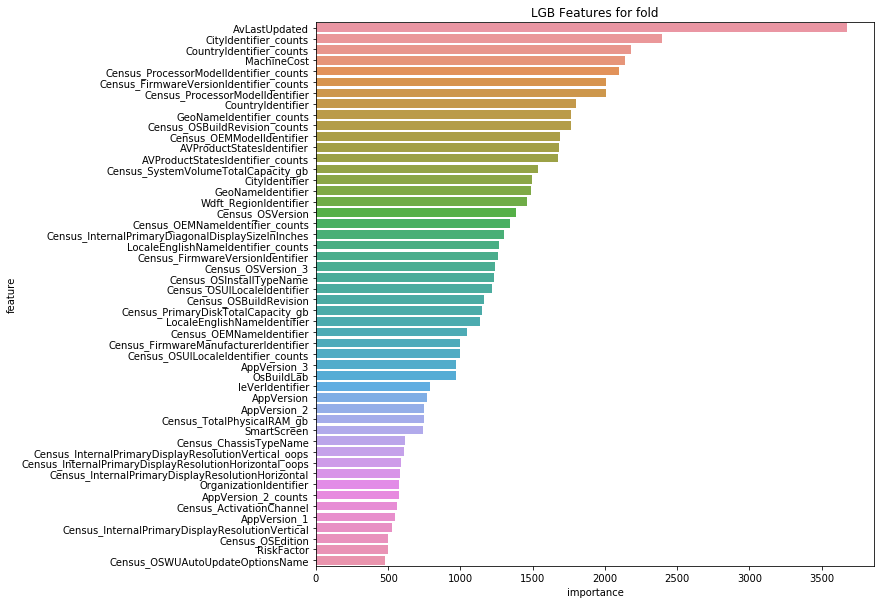

In [383]:
min_dat_sub = train_and_test_model(train_final, test_final, y_trn, test_params, num_folds=3, plot_feature_importance=True, )

In [ ]:
create_submission(min_dat_sub, 'final_sub.csv')

In [ ]:
from category_encoders.hashing import HashingEncoder

In [ ]:
enc = HashingEncoder(verbose=1, n_components=1, cols=categorical, drop_invariant=True, return_df=True)
enc.fit(train_final)

In [ ]:
hashed = enc.transform(train_final)